# fast estimation of particle properties
Tim Tyree<br>
9.29.2021<br>
`conda activate pyenv_ub`

__GOALS__:
- DONE: compute dRdt versus 1/R for unconstrained random samples from smoothed and validated trajectories
- TODO: compute a from a bootstrap of 1/R versus a for one input_fn
- TODO: compute a from a bootstrap of 1/R versus a for one input_fn_lst
- TODO: compute a from a bootstrap of 1/R versus a for each input_fn_lst
- TODO: repeat for measuring ensemble MSD to give the diffusion coefficient, D
- TODO(later?): efficiently generate an _inline_ rendering of dRdt versus 1/R and MSD versus tau using dashly.  try the solution suggested on my stackoverflow post
- TODO: generate a .bluf for each input_fn_lst to document the particle property measurements
- TODO: show qualitative insenstivity to choice in navg1 and navg2

__TODO(later):__ bug mike to make certain that for the 99.95% accurate decoder, that the i^th neuron for the Match trials is the same as the i^th neuron for the Mismatch trials for all i neuron-units considered.

howdo hierarchical multi-indexing: https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html#hierarchical-indexing-multiindex

In [1]:
from lib.my_initialization import *
from lib import *
# from lib.measure.unwrap_and_smooth_cu import *
# from lib.rapids_func import *
# .routines.unwrap_and_smooth_trajectories_cu import *

import itertools
import dask_cudf
from lib.rapids_func import *
get_DT_cu

#magic    
%autocall 1
%load_ext autoreload
%autoreload 2

import cupy as cp, cudf, numba.cuda as cuda
import rmm
# Switch to RMM allocator
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

Automatic calling is: Smart


In [2]:
from lib.rapids_func import *

In [3]:
darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

# (optional) postprocess a token trajectory file
- Nota Bene: batch computation is already automated and optimized in 'fast postprocessing a list of trajectory folders.ipynb'

In [4]:
tavg1=4#8#4 #moving average window, in ms

# tavg2=12#24 #ms #savgol_filter time window performed on R 
tavg2=24# #ms #savgol_filter time window performed on R  #12 ms was no longer smooth
# tavg2=10.# #ms #savgol_filter time window performed on R  #12 ms was no longer smooth

In [31]:
# #particle model token trajectories
# input_fn_lst = [
#     '/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/euic_False_fc_2_r_0.1_D_0_L_10_kappa_0_varkappa_0/Log/pbc_particle_log1_log.csv',
#     '/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/euic_False_fc_2_r_0.1_D_0_L_10_kappa_1500_varkappa_5/Log/pbc_particle_log2_log.csv',
#     '/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/euic_False_fc_2_r_0.1_D_2_L_10_kappa_0_varkappa_0/Log/pbc_particle_log5_log.csv',
#     '/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/euic_False_fc_2_r_0.1_D_2_L_10_kappa_1500_varkappa_0/Log/pbc_particle_log5_log.csv',
#     '/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/euic_False_fc_2_r_0.1_D_2_L_10_kappa_1500_varkappa_5/Log/pbc_particle_log5_log.csv'
# ]
# input_fn=input_fn_lst[-1]
# print(input_fn)

# pid_col='pid_explicit'
# width=10
# ds=10. #cm for the whole domain
# tmin=0.
# c='C3'

In [92]:
# input_fn=search_for_file()
# c='C0'
# # # # #token FK at DT=0.4
# # input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.2_traj_sr_400_mem_0.csv"

c='C1'
# #tokenLR at DT=0.5
# input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/trajectories/ic002.31_traj_sr_600_mem_0.csv"
input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/trajectories/ic002.11_traj_sr_600_mem_0.csv"

pid_col='particle'
width=200
ds=5. #cm for the whole domain
tmin=100.


#test routine on one file
testing=True
if testing:
    t_col='t'
    df=pd.read_csv(input_fn)
    DT=np.around(get_DT(df, t_col=t_col, pid_col=pid_col),5);print(f"DT={DT}")
    # ds=5 #cm
    # DS=ds/width
#     width=200
    height=width
    use_drop_shorter_than=True
    drop_shorter_than=50 #ms
#     tmin=100.#ms
#     pid_col='particle'
    
    printing=False
    navg1=int(tavg1/DT)
    save_dir=return_moving_average_of_pbc_trajectories_and_save(
            input_fn, tavg1, pid_col, t_col, DT, width, height,
            use_drop_shorter_than, drop_shorter_than, tmin, printing)
    print(save_dir)

    df=load_smoothed_trajectories(save_dir,pid_col,t_col)
    df.head()

DT=0.5
/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/smoothed_trajectories_tavg_4/ic002.11_traj_sr_600_mem_0_smoothed.csv


In [93]:
# input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/smoothed_trajectories_tavg_4/ic002.11_traj_sr_600_mem_0_smoothed.csv"
input_fn=save_dir
dfr_dir=routine_compute_radial_velocities_pbc_cu(input_fn,
                                             tavg2,
                                             width,  #for handling periodic boundary conditions (pbc)
                                             height, #for handling periodic boundary conditions (pbc)
                                             ds,     #domain size in cm.  set to width to have nulled effect
                                             max_dtmax_thresh = 0,      #ms
                                             max_Rfinal_thresh = 0.2,   #cm
                                             min_duration_thresh = 40,  #ms
                                             round_t_to_n_digits=7,
                                             trial_col='event_id_int',
                                             pid_col='particle',
                                             t_col='t',
                                             use_tavg2=True,
                                             save_df_pairs=True,
                                             printing=True,
                                             testing=True)#,**kwargs)

DT=0.5 ms
savistzky-golay time window in use: 24.5 ms
using 1 cores to identify pairs of particles that coexist over 1 independent trials...
selected 72 particle pairs as annihilating out of 11851 possible particle pairs
radial velocities of annihilation events were successfully saved to csv


# estimate the attraction coefficient

In [371]:
input_fn=search_for_file('/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/euic_False_fc_2_r_0.1_D_2_L_10_kappa_1500_varkappa_5/')

File: /home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/euic_False_fc_2_r_0.1_D_2_L_10_kappa_1500_varkappa_5/smoothed_annihilations_tavg1_4.0_tavg2_14.25_maxdtmax_0_maxRfin_0.2_mindur_15/pbc_particle_log8_log_smoothed_annihilations_denoised.csv


In [4]:
input_fn='/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/euic_False_fc_2_r_0.1_D_2_L_10_kappa_1500_varkappa_5/smoothed_annihilations_tavg1_4.0_tavg2_14.25_maxdtmax_0_maxRfin_0.2_mindur_15/pbc_particle_log8_log_smoothed_annihilations_denoised.csv'
input_fn_lst=get_all_files_matching_pattern(input_fn,'.csv')
len(input_fn_lst)

199

In [16]:
dfr=dask_cudf.read_csv(input_fn_lst).compute()
DT=get_DT_cu(dfr, t_col='t', pid_col='pid_self', round_digits=7)
print(f"DT={DT}")

DT=0.25


In [17]:
# dfr=cudf.read_csv(dfr_dir)
dfr=dfr.sort_values(by=['event_id_int','pid_self','tdeath'],ascending=True)
dfr.head()

,event_id_int,pid_self,pid_other,index,t,R,index_pairs,index_self,index_other,x_self,y_self,x_other,y_other,R_nosavgol,tdeath
970,11,3,6,970,242.50,0.062662,0,8749,8751,3.247940,0.913733,3.302219,1.030398,0.128673,0.00
969,11,3,6,969,242.25,0.106208,0,8743,8745,3.283808,0.900760,3.342833,0.986914,0.104434,0.25
968,11,3,6,968,242.00,0.148962,0,8737,8739,3.211739,0.874735,3.332027,0.991297,0.167499,0.50
967,11,3,6,967,241.75,0.190918,0,8731,8733,3.214015,0.839503,3.283824,1.041968,0.214162,0.75
966,11,3,6,966,241.50,0.232068,0,8725,8727,3.263996,0.857973,3.285246,1.047749,0.190962,1.00


In [18]:
dfr.shape

(1108942, 15)

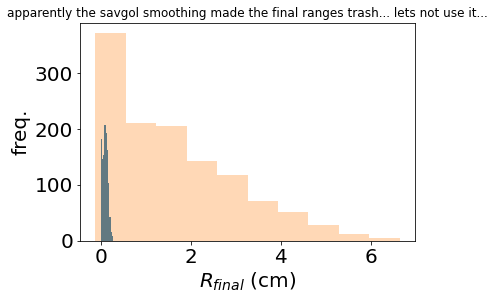

In [21]:
#TODO: try subtracting off the first value of R_nosavgol
plt.hist(dfr.loc[dfr['tdeath']==0,'R_nosavgol'].values.get(),alpha=1.)
plt.hist(dfr.loc[dfr['tdeath']==0,'R'].values.get(),alpha=0.3)
format_plot(ax=plt.gca(), xlabel=r'$R_{final}$ (cm)', ylabel='freq.', fontsize=20)
plt.title(f'apparently the savgol smoothing made the final ranges trash... lets not use it...')
plt.show()

In [22]:
dfr=dfr.set_index(['event_id_int','pid_self','pid_other'])
df_r0=dfr.loc[dfr['tdeath']==0,'R_nosavgol']
#subtract off zero without savgol
dfr['R_nosavgol0']=df_r0
dfr['R_nosavgol0']=dfr['R_nosavgol']-dfr['R_nosavgol0']
#subtract off zero with savgol
df_r0=dfr.loc[dfr['tdeath']==0,'R']
dfr['R0']=df_r0
dfr['R0']=dfr['R']-dfr['R0']
dfr.reset_index(inplace=True)
dfr.head()

,event_id_int,pid_self,pid_other,index,t,R,index_pairs,index_self,index_other,x_self,y_self,x_other,y_other,R_nosavgol,tdeath,R_nosavgol0,R0
0,11,3,6,970,242.50,0.062662,0,8749,8751,3.247940,0.913733,3.302219,1.030398,0.128673,0.00,0.000000,0.000000
1,11,3,6,969,242.25,0.106208,0,8743,8745,3.283808,0.900760,3.342833,0.986914,0.104434,0.25,-0.024239,0.043546
2,11,3,6,968,242.00,0.148962,0,8737,8739,3.211739,0.874735,3.332027,0.991297,0.167499,0.50,0.038826,0.086300
3,11,3,6,967,241.75,0.190918,0,8731,8733,3.214015,0.839503,3.283824,1.041968,0.214162,0.75,0.085489,0.128256
4,11,3,6,966,241.50,0.232068,0,8725,8727,3.263996,0.857973,3.285246,1.047749,0.190962,1.00,0.062288,0.169406


In [82]:
use_subtract_Rfinal=True
if use_subtract_Rfinal:
    dfr['SR']=dfr['R_nosavgol0']**2  #looks nice but the values are too small to be reasonable
    dfr['SR']=dfr['R0']**2 #does not work reasonably well
else:
    dfr['SR']=dfr['R_nosavgol']**2  #works reasonably well
    dfr['SR']=dfr['R']**2  #does not work reasonably well

mean_R_vs_tdeath=dfr.groupby('tdeath')[['SR']].describe()['SR'][['mean','count']]

In [83]:
#identify the max tdeath with the max number of counts
tmaxmax=mean_R_vs_tdeath['count'].max()
boo=tmaxmax==mean_R_vs_tdeath['count']
tdeath_values=mean_R_vs_tdeath[boo].index.values.get()+DT
SR_values=mean_R_vs_tdeath[boo]['mean'].values.get()

In [84]:
assert(np.min(tdeath_values)==DT)

In [85]:
def comp_a_SR(tdeath_values,SR_values,tmax):
    '''
    Example Usage:
    a_SR, Delta_a_SR, Rsq_a_SR = comp_a_SR(tdeath_values,SR_values,tmax)
    '''
    boo=tdeath_values<tmax
    x=tdeath_values[boo]/1000 #s
    y=SR_values[boo]# cm^2
    dict_force_fit=compute_95CI_ols(x,y)
    a_SR=dict_force_fit['m']/4
    Delta_a_SR=dict_force_fit['Delta_m']/4
    Rsq_a_SR=dict_force_fit['Rsquared']
    return a_SR, Delta_a_SR, Rsq_a_SR

In [86]:
#TODO: compute a using numpy
tmax=25#ms
printing=True
a_SR, Delta_a_SR, Rsq_a_SR = comp_a_SR(tdeath_values,SR_values,tmax)
if printing:
    print(f"a={a_SR:.4f}+-{Delta_a_SR:.4f} cm^2/s. (R^2={Rsq_a_SR:.4f})")

a=5.3802+-0.1620 cm^2/s. (R^2=0.9865)


In [88]:
#compute a versus tmax
tmax_values=np.arange(9*DT,tmaxmax,DT)
a_SR_lst=[];Delta_a_SR_lst=[];Rsq_a_SR_lst=[]
for tmax in tmax_values:
    a_SR, Delta_a_SR, Rsq_a_SR = comp_a_SR(tdeath_values,SR_values,tmax)
    #record results
    a_SR_lst.append(a_SR)
    Delta_a_SR_lst.append(Delta_a_SR)
    Rsq_a_SR_lst.append(Rsq_a_SR)

a_SR_values=np.array(a_SR_lst)
Delta_a_SR_values=np.array(Delta_a_SR_lst)

In [89]:
# #DONE: bootstrap Delta_SR_values
# Delta_SR_values=SR_values*0.05

In [90]:
# Delta_SR_lst=[]
# for t in tdeath_values:
#     x=dfr.loc[dfr['tdeath']==t,'SR'].values.get()
#     Delta_x=bootstrap_stdev_of_mean(x=g['SR'].values,num_samples=1000)
#     Delta_SR_lst.append(Delta_x)


In [91]:
def routine_boostrap_tdeath_group(tdeath):
    x=df_r.loc[df_r['tdeath']==tdeath,'SR'].values
    #Delta_x, p_x = bootstrap_95CI_Delta_mean(x,num_samples=100)
    Delta_x, p_x = bootstrap_95CI_Delta_mean(x,num_samples=1000)
    return (tdeath,Delta_x, p_x)

df_r=dfr.to_pandas()

In [92]:
npartitions=os.cpu_count()
#all CPU version
b = db.from_sequence(tdeath_values, npartitions=npartitions).map(routine_boostrap_tdeath_group)
start = time.time()
retval = list(b)
if printing:
    print(f"run time for bootstrapping each time value was {time.time()-start:.2f} seconds.")

df_boostrapped=pd.DataFrame(data=np.array(retval), columns=['tdeath','Delta_SR','p_SR'])

run time for bootstrapping each time value was 8.86 seconds.


In [93]:
Delta_SR_values=df_boostrapped['Delta_SR'].values
#apparently all bootstrapped mean values are significantly different from the normal distribution for the full simulation...
percent_normal=sum(df_boostrapped['p_SR']>0.05)/df_boostrapped['p_SR'].shape[0]*100
print(f"percent of normally distributed time bins appears to be {percent_normal:.3f}%")

Delta_SR_values=df_boostrapped['Delta_SR'].values

percent of normally distributed time bins appears to be 1.667%


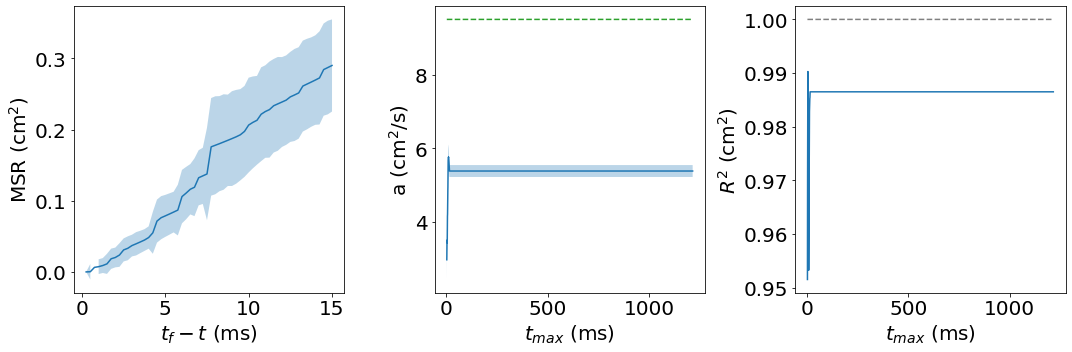

In [94]:
fontsize=20
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15,5), ncols=3)#, sharex=True)
ax1.plot(tdeath_values,SR_values)
ax1.fill_between(tdeath_values,SR_values-Delta_SR_values,SR_values+Delta_SR_values,alpha=0.3)
ax2.plot(tmax_values,a_SR_lst)
ax2.fill_between(tmax_values,a_SR_values-Delta_a_SR_values,a_SR_values+Delta_a_SR_values,alpha=0.3)
ax2.plot(tmax_values,0.*tmax_values+9.5,'C2--')
ax3.plot(tmax_values,Rsq_a_SR_lst)
ax3.plot(tmax_values,0.*tmax_values+1.,'gray',linestyle='dashed')
format_plot(ax=ax1, xlabel=r'$t_{f}-t$ (ms)', ylabel=r'MSR (cm$^2$)', fontsize=fontsize, use_loglog=False)
format_plot(ax=ax2, xlabel=r'$t_{max}$ (ms)', ylabel=r'a (cm$^2$/s)', fontsize=fontsize, use_loglog=False)
format_plot(ax=ax3, xlabel=r'$t_{max}$ (ms)', ylabel=r'$R^2$ (cm$^2$)', fontsize=fontsize, use_loglog=False)
plt.tight_layout()
plt.show()

In [95]:
if printing:
    print(f"a={a_SR:.4f}+-{Delta_a_SR:.4f} cm^2/s. (R^2={Rsq_a_SR:.4f})")

a=5.3802+-0.1620 cm^2/s. (R^2=0.9865)


In [47]:
#TODO: compute mean squared range
#TODO: bootstrap 95% CI for R for each tdeath value
#TODO: repeat for R_nosavgol
#TOOD: repeat for R subtracting off the initial value for each annihilation event
#TODO: compute a, Delta_a and Rsquared versus tmax using OLS from tdeath=0 to tdeath=tmax
#TODO: return a, Delta_a and Rsquared versus tmax for placement in a pandas dataframe
#TODO: save bluf to .pdf

In [8]:
#TODO: compute a using numpy
tmax=25#ms
boo=tdeath_values<tmax
x=tdeath_values[boo]/1000 #s
y=SR_values[boo]# cm^2
dict_force_fit=compute_95CI_ols(x,y)
a_SR=dict_force_fit['m']/4
Delta_a_SR=dict_force_fit['Delta_m']/4
Rsq_a_SR=dict_force_fit['Rsquared']

fontsize=20
plt.plot(x,y,c)
plt.plot(x,x*1.9*4,'C0--')
plt.plot(x,x*9.5*4,'C1--')
plt.plot(x,x*5*4,'C3--')

# print_dict(dict_force_fit)
format_plot(ax=plt.gca(), xlabel=r'$t_f-t$ (seconds)', ylabel=r'MSR $cm^2$', fontsize=fontsize, use_loglog=False)
# format_plot(ax=plt.gca(), xlabel=r'$t_f-t$ (seconds)', ylabel=r'$R^2$ $cm^2$', fontsize=fontsize, use_loglog=False)
print(f"a={a_SR:.4f}+-{Delta_a_SR:.4f} cm^2/s. (R^2={Rsq_a_SR:.4f})")
plt.title(f'tmax={tmax:.3f} seconds\n')
plt.show()

In [9]:
# #TODO(later): compute squared displacements
# grouped=df.groupby(pid_col)
# #HINT: squared displacements of particles is result
#  throws AttributeError: DataFrameGroupBy object has no attribute first 
# result = (grouped[['x','y']]-grouped[['x','y']].first())**2

In [10]:
#TODO(later): implement a one_step method on an element in a finite element simulation
# HINT: cudf.Grouper?
# HINT: https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#grouping-with-a-grouper-specification
# HINT: https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#transformation

In [11]:
#DONE: figure out if there's an elegant was to use the cudf api  to do this
#for each group of event_id_int's :
#compare every particle to every other particle in a simple way
#compare every particle to every other particle to determine if the self,other pair intersects nontrivially

#DONE: determine condition for whether each pair is intersecting for at least two times 
# two particles exist for at least two times if both
#if other has a tmin > tmin of self
#AND if other has a tmax < tmax of self, 

# #DONE: construct the graph of all edges... this wasn't useful...
# G = cugraph.Graph()
# G.from_cudf_edgelist(df_pairs, source='src', destination='dst', edge_attr='dst')
# # # Let's now get the PageRank score of each vertex by calling cugraph.pagerank
# # df_page = cugraph.pagerank(G)
# # df_page.head()

In [12]:
#DONE: compute which edges are intersecting
#DONE: compute tmin and tmax for each intersecting edge
#DONE: compute duration for each intersecting edge
#DONE: sort edges by duration
#DONE: visualize the histogram of durations of intersecting edges
#DONE: consider a minimum_duration_threshold that is at least tavg2 if not specified

## scratchwerk

In [13]:
#DONT: figure out terrible numba debugging for a negligible speed boost
# @cuda.jit()#device=True)
# def distance_L2_pbc_cuda(point_1, point_2, dist_out, shape):
#     '''distance_L2_pbc_cu is a jit compiled function that 
#     returns for the euclidean (L2) distance between 
#     point_1 and point_2, which are in an N-cube of shape shape 
#     with periodic boundary conditions
    
#     Example Usage:
#     blockspergrid=1
#     threadsperblock=1
#     point_1=self_values[0]
#     point_2=other_values[0]
#     dist_out=0.#overwritten
#     shape=(width,height)
#     distance_L2_pbc_cuda[blockspergrid, threadsperblock](point_1, point_2, dist_out, shape)
#     '''
#     dq2 = 0.
#     for q1, q2, wid in zip(point_1, point_2, shape):
#         dq2 = dq2 + min(((q2 - q1)**2, (q2 + wid - q1 )**2, (q2 - wid - q1 )**2))
#     dist_out= dq2**0.5

# blockspergrid=1
# threadsperblock=1
# point_1=self_values[0]
# point_2=other_values[0]
# dist_out=np.array([0.])#*self_values
# shape=(width,height)
# # distance_L2_pbc_cuda(point_1, point_2, dist_out, shape)
# distance_L2_pbc_cuda[blockspergrid, threadsperblock](point_1, point_2, dist_out, shape)
# dist_out, point_1, point_2

# from numba import vectorize
# # shape=(width,height)
# # @vectorize(['float32[:](float32, float32, float32)'], target='cuda')
# shape=cp.array((width,height))
# @vectorize(['(float32[:,:], float32[:,:], float32[:,:], float32[:])'], target='cuda')
# def distance_L2_pbc_cu(self_values, other_values, dist_out_values, shape):
#     for point_1, point_2, dist_out in zip(self_values, other_values, dist_out_values):
#         distance_L2_pbc_cuda(point_1, point_2, dist_out, shape)

# # blockspergrid=1
# # threadsperblock=1
# dist_out_values=0.*self_values
# shape=cp.array((width,height))
# distance_L2_pbc_cu(self_values, other_values, dist_out_values, shape)
# # distance_L2_pbc_cuda[blockspergrid, threadsperblock](point_1, point_2, dist_out, shape)
# # dist_out

In [14]:
# def extract_xy_values_of_pair(df,pair,t_col='t'):
#     '''
#     df is a cudf.DataFrame instance of xy trajectories from no more than 1 trial 
#     pair is a row from a pandas.core.series.Series instance with columns,['pid_self', 'pid_other', 'tmin_self', 'tmin_other', 'tmax_self', 'tmax_other', 'tmin', 'tmax', 'duration', 'event_id_int']
    
#     Example Usage:
#     pair=pd.Series(df_pairs.head(1).to_pandas())
#     event_id_int=int(pair[trial_col])#.values.get())
#     dff=df[df[trial_col]==event_id_int]
#     self_values,other_values=extract_xy_values_of_pair(df=dff,pair=pair,t_col=t_col)
#     '''
#     dff=df
#     #DONE: optimize data retrieval from pair by using only one gpu-to-cpu memory transfer
#     pid_self =int(pair['pid_self'])#.values.get())
#     pid_other=int(pair['pid_other'])#.values.get())
#     tmin     =float(pair['tmin'])#.values.get())
#     tmax     =float(pair['tmax'])#.values.get())
#     #failed to broadcase in cudf
#     #     if event_id_int is not None:
#     #         dff=df[df[trial_col]==event_id_int]
#     #     else:
#     #         dff=df
#     df_self =dff.loc[(dff[pid_col]==pid_self),[t_col,'x','y']]
#     df_other=dff.loc[(dff[pid_col]==pid_other),[t_col,'x','y']]
#     self_values=df_self.loc[(df_self[t_col]>=tmin)&(df_self[t_col]<=tmax),['x','y']].values
#     other_values=df_other.loc[(df_other[t_col]>=tmin)&(df_other[t_col]<=tmax),['x','y']].values
#     return self_values,other_values

In [15]:
# pair=df_pairs.head(1)
# event_id_int=int(pair[trial_col].values.get())
# dff=df[df[trial_col]==event_id_int]
# self_values,other_values=extract_xy_values_of_pair(df=dff,pair=pair,t_col=t_col)
# print((self_values.shape,other_values.shape))
# assert ( self_values.shape==other_values.shape ) 

In [16]:
#this function may be slow and might not even work...
# def distance_L2_pbc_cu(self_values,other_values,shape):
#     '''distance_L2_pbc_cu is a jit compiled function that 
#     returns for the euclidean (L2) distance between 
#     point_1 and point_2, which are in an N-cube of shape shape 
#     with periodic boundary conditions
    
#     Example Usage:
#     shape=(width,height)
#     dist_values=distance_L2_pbc_cu(self_values,other_values,shape)
#     '''
#     sqdiff_values = (self_values-other_values)**2
#     #compute the other pbc options for sqdiff_values for each column
#     for n,w in enumerate(shape):
#         self_w_values  = self_values[:,n]
#         other_w_values = other_values[:,n]
#         sqdiff_w_values= sqdiff_values[:,n]
#         sqdiff_wp_values=(self_w_values-other_w_values-w)**2
#         sqdiff_wm_values=(self_w_values-other_w_values+w)**2
#         boop=sqdiff_wp_values<sqdiff_w_values
#         boom=sqdiff_wm_values<sqdiff_w_values
#         sqdiff_values[boop,n]=sqdiff_wp_values[boop]
#         sqdiff_values[boom,n]=sqdiff_wm_values[boom]

#     dist_values=cp.sqrt(cp.sum(sqdiff_values,axis=1))
#     return dist_values

In [17]:
#DONE: histograms sanity check df_intersecting_pairs
#DONE: verify that routine gives different values for different event_id_int
#DONE: wrap generation of df_intersecting_pairs into a function 
#DONE: include event_id_int outside ^that function
#DONE: accumulate df_intersecting_pairs_all over all event_id_int_values

# define module

# DONE: compute the radial velocities with naive finite difference

__Note:__ cugraph is a great tool for complex problems that happen in terms of graphs that benefit from visualization.  My graph problem is low-level, and therefore it does not appear beneficial for me to use cugraph here.

In [22]:
# #TODO: figure out why I'm getting pid_self==pid_other in the R versus time plot...
# #recall a couple postprocessed single trials
# input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/smoothed_trajectories_navg_8/ic002.11_traj_sr_600_mem_0_smoothed.csv"
# input_fn2=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/smoothed_trajectories_navg_8/ic002.12_traj_sr_600_mem_0_smoothed.csv"

# # # # # #token FK at DT=0.4
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/smoothed_trajectories_tavg_4/ic200x200.0.2_traj_sr_400_mem_0_smoothed.csv"

#what was just done up ^there
# input_fn=save_dir


# input_fn_lst=[input_fn,input_fn2]
# # input_fn_lst=get_all_files_matching_pattern(input_fn,trgt='.csv')
# # print(f"loading {len(input_fn_lst)} files into shared memory...")

In [23]:
# str(eval('hello\nworld'.__repr__))

In [25]:
#TODO: compute attraction coefficient by loading all trajectories from ^that file using the mean squared range method
#     save_fn = '__'.join(input_fn.split('/')[-3:-1]) + ext  #aggregate all results

In [26]:
#TODO(then): compute diffusion coefficient by loading smoothed trajectories using the mean squared displacement method
#HINT: load_smoothed_trajectories

# DONE: plots describing methods

In [27]:
# #extract the xy values for observations in range if they are the final observation for a given pair
# max_times=dfr.reset_index().groupby([trial_col,'pid_self','pid_other'])[t_col].max().reset_index().values
# last_obs=dfr.reset_index().set_index([trial_col,'pid_self','pid_other',t_col]).loc[max_times.get().T]
# x_values,y_values=last_obs[['one_over_R','dRdt']].values.T
# last_range=last_obs['R'].values.T
# last_dRdt=y_values

In [28]:
#TODO(after computing the final SR versus tdeath vlaues):subtract off the first squared range and tdeath value for each pair considered

In [29]:
#test that duration is strictly positive
assert ( (df_intersecting_pairs_all['duration']>0).all() )
if printing:
    print (f"verified that the duration is strictly positive for all pairs of tips that coexist nontrivially")

#plot histogram of durations
fontsize=20
fig,ax=plt.subplots(figsize=(7,4))
yv=np.linspace(0,0.02,10)
ax.plot(minimum_duration_threshold+0.*yv,yv,'gray',lw=2, linestyle='dashed', label='threshold')
trial_col_lst=sorted(df_intersecting_pairs_all[trial_col].drop_duplicates().values.get())
for trial in trial_col_lst[:5]:
    df_intersecting_pairs_all.query(f"{trial_col} == {trial}")['duration'].to_pandas().hist(density=True,bins=50,ax=ax,label=trial,grid=False)#,color='event_id_int')
format_plot(ax, xlabel='duration of pair coexistance (ms)', ylabel='probability density', fontsize=fontsize, use_loglog=False)

ax.legend(fontsize=fontsize)
plt.tight_layout()
plt.show()

NameError: name 'df_intersecting_pairs_all' is not defined

In [ ]:
#DONE: verify that no pair points to the same spiral tip twice
assert ( not (df_intersecting_pairs_all['pid_self']==df_intersecting_pairs_all['pid_other']).any() )

In [ ]:
# df.dropna()

In [ ]:
grouped=df.groupby([trial_col,pid_col])
dft=grouped[t_col]
dfu=cudf.DataFrame({
    'tmin':dft.min(),
    'tmax':dft.max(),
})
dfu.reset_index(inplace=True)
df_intersecting_pairs_all=identify_all_coexisting_pairs(df=dfu.copy(),pid_col=pid_col,t_col=t_col,trial_col=trial_col)

#filter by duration_threshold
use_duration_threshold=True
if use_duration_threshold:
    df_pairs=df_intersecting_pairs_all[df_intersecting_pairs_all['duration']>minimum_duration_threshold]
else:
    df_pairs=df_intersecting_pairs_all
#and sort
df_pairs=df_pairs.sort_values([trial_col,'pid_self'], ascending=True).copy()

In [ ]:
df_traj=extract_trajectory_pairs_cu(df,df_pairs,pid_col,t_col,trial_col,DT)
#DONE: tested that index_self is never equal to index_other for a given event_id_int
#^this is equivalent to no two observations being the same
trial_values=df[trial_col].drop_duplicates().values
for trial in trial_values.get():
    d=df_traj.loc[df_traj[trial_col]==trial].copy()
    assert ( not (d['index_other']==d['index_self']).any())

In [ ]:
#compute the naive finite difference radial velocity between all pairs of particles
df_traj=comp_xy_distance_L2_pbc_cu(df_traj,width,height)
df_traj['R']=df_traj['dist']*DS #cm
#isolate only the columns relevant to computing the attraction coefficient, a
df_R=df_traj[[trial_col,'pid_self','pid_other',t_col,'R']].dropna()
df_R=df_R.sort_values([trial_col,'pid_self','pid_other',t_col], ascending=True).copy()
grouped=df_R.groupby([trial_col,'pid_self','pid_other'])
#compute the difference between two successive R values for each group
df_R['incol']=df_R['R']
mdwargs={'win_size':2}
result = grouped.apply_grouped(rolling_diff,
                               incols=['incol'],
                               outcols=dict(outcol=np.float64), kwargs=
                           mdwargs)
df_R['dRdt']=result['outcol']/DT*1000 #cm/s
df_R.drop(columns=['incol'],inplace=True)
#compute the average between two successive R values for each group
df_R['incol']=df_R['R']
mawargs={'win_size':2}
result = grouped.apply_grouped(rolling_avg,
                               incols=['incol'],
                               outcols=dict(outcol=np.float64), kwargs=
                           mawargs)
df_R['R_midpoint']=result['outcol'] #cm
df_R['one_over_R']=1./df_R['R'] #1/cm
df_R.drop(columns=['incol'],inplace=True)
df_R.dropna(inplace=True)
df_R.head()

In [ ]:
#index by individual pairs
dfr=df_R.set_index([trial_col,'pid_self','pid_other']).sort_values(by='t')
#identify all pairs that are within this range
boo=(dfr['R']<=maximum_range_threshold)&(dfr['R']>=minimum_range_threshold)
index_values=dfr.index.drop_duplicates().values

x_values,y_values=dfr.sort_values(by='t')[['one_over_R','dRdt']].values.T.get()
print(f"any(1/R < 0)={(x_values<0).any()}")
# boo=x_values<0
# # print(x_values[boo])
# # ,'one_over_R']
# next_=dfr[boo].index+1
# dfr.loc[next_,'one_over_R']
# dfr[boo]

In [ ]:
# dfr[boo]

In [ ]:
# any

In [ ]:
# dfr.shift(-1)[boo]

In [ ]:
#plot histogram of durations
fontsize=20
fig,ax=plt.subplots(figsize=(7,4))

trial_col_lst=sorted(df_R[trial_col].drop_duplicates().values.get())
for trial in trial_col_lst[:5]:
    df_R.query(f"{trial_col} == {trial}")['R_midpoint'].to_pandas().hist(density=True,bins=50,ax=ax,label=trial,grid=False)#,color='event_id_int')
        
format_plot(ax, xlabel=r'$R$ (cm)', ylabel='prob. density', fontsize=fontsize, use_loglog=False)
ax.legend(fontsize=fontsize-2)

#plot threshold lines
yv=np.linspace(0,0.6,10)
ax.plot(minimum_range_threshold+0.*yv,yv,'gray',lw=2, linestyle='dashed', label='threshold')
ax.plot(maximum_range_threshold+0.*yv,yv,'gray',lw=2, linestyle='dashed', label='threshold')

plt.tight_layout()
plt.show()

In [ ]:
xmin=-100
xmax=100

In [ ]:
#DONE: plot a laplace distribution over ^this
xv=df_R.query(f"{trial_col} == {trial}")['dRdt'].values.get()
v=xv[(xv>xmin)&(xv<xmax)]
mu=np.mean(v)
beta=np.std(v)/np.sqrt(2)
def comp_laplace_pdf(x,mu,beta):
    return np.exp(-np.abs(x-mu)/beta)/(2*beta)

In [ ]:
#plot histogram of durations
fontsize=20
fig,ax=plt.subplots(figsize=(7,4))
trial_col_lst=sorted(df_R[trial_col].drop_duplicates().values.get())
for trial in trial_col_lst[:5]:
    xv=df_R.query(f"{trial_col} == {trial}")['dRdt'].values.get()
    v=xv[(xv>xmin)&(xv<xmax)]# np.max(xv),np.quantile(xv,.15),np.mean(xv),np.quantile(xv,.85),np.max(xv)
    ax.hist(v,density=True,bins=50,label=trial)#,grid=False)#,color='event_id_int')
#     ax.hist(v,density=True,bins='auto',label=trial)#,grid=False)#,color='event_id_int')
 

#plot the max likelihood fit to the laplace distribution
x_values=np.linspace(xmin,xmax,100)
laplace_values=comp_laplace_pdf(x_values,mu,beta)
plt.plot(x_values,laplace_values,'g--',lw=4,alpha=0.4,label='Laplace Fit')

format_plot(ax, xlabel=r'$dR/dt$ (cm)', ylabel='prob. density', fontsize=fontsize, use_loglog=False)
ax.legend(fontsize=fontsize-4,loc='lower center')
ax.set_yscale('log')
ax.set_xlim([xmin,xmax])
ax.set_title(f'fit parameters: mu={mu:.3f} cm, beta={beta:.3f} cm\n')
# ax.set_ylim([0,0.01])
plt.tight_layout()
plt.show()

In [ ]:
#index by individual pairs
dfr=df_R.set_index([trial_col,'pid_self','pid_other']).sort_values(by='t')
#identify all pairs that are within this range
boo=(dfr['R']<=maximum_range_threshold)&(dfr['R']>=minimum_range_threshold)
index_values=dfr.index.drop_duplicates().values

In [ ]:
#plot a few particle events
fontsize=14
fig,ax=plt.subplots(figsize=(7,5))
for iv in index_values.get()[:3]:
    x_values,y_values=dfr.loc[iv].sort_values(by='t')[['t','R']].values.T.get()
    ax.plot(x_values-x_values[0],y_values,label=f"pair {(iv[1],iv[2])}")
format_plot(ax, xlabel=r'$t$ (ms)', ylabel=r'$R$ (cm)', fontsize=fontsize, use_loglog=False)
ax.legend(fontsize=fontsize-2)
plt.title(f'tavg1={tavg1} ms, tavg2={0} ms\n')
plt.tight_layout()
plt.show()

In [ ]:
#plot a few particle events
fontsize=14
fig,ax=plt.subplots(figsize=(7,4))
for iv in index_values.get()[:3]:
    x_values,y_values=dfr.loc[iv].sort_values(by='t')[['R_midpoint','dRdt']].values.T.get()
#     ax.scatter(x_values,y_values,label=f"pair {(iv[1],iv[2])}")
    ax.plot(x_values,y_values,label=f"pair {(iv[1],iv[2])}")
format_plot(ax, xlabel=r'$R$ (cm)', ylabel=r'$dR/dt$ (cm/s)', fontsize=fontsize, use_loglog=False)
ax.legend(fontsize=fontsize-2)
plt.tight_layout()
plt.show()

# DONE: compute the radial velocities with the savgol_filtered 

In [ ]:
savgol_kwargs=dict(
    window_length=navg2,
    polyorder=3,
    deriv=1,
    delta=1.0,
    axis=-1,
    mode='interp'
)

savgol0_kwargs=dict(
    window_length=navg2,
    polyorder=3,
    deriv=0,
    delta=1.0,
    axis=-1,
    mode='interp'
)

df_traj=extract_trajectory_pairs_cu(df,df_pairs,pid_col,t_col,trial_col,DT)
#compute the naive finite difference radial velocity between all pairs of particles
df_traj=comp_xy_distance_L2_pbc_cu(df_traj,width,height)
df_traj['R']=df_traj['dist']*DS #cm
#isolate only the columns relevant to computing the attraction coefficient, a
df_R=df_traj[[trial_col,'pid_self','pid_other',t_col,'R']].dropna()
df_R=df_R.sort_values([trial_col,'pid_self','pid_other',t_col], ascending=True)#.copy()

#compute the smoothed derivative savgol_filter using scipy's cryptic cython code
grouped=df_R.to_pandas().groupby([trial_col,'pid_self','pid_other'])
result = grouped['R'].apply(savgol_filter,**savgol_kwargs)
dRdt_values=cp.array(np.concatenate(result.values))
df_R['dRdt']=dRdt_values/DT*1000

#compute the smoothed value savgol_filter using scipy's cryptic cython code
grouped=df_R.to_pandas().groupby([trial_col,'pid_self','pid_other'])
result = grouped['R'].apply(savgol_filter,**savgol0_kwargs)
R_values=cp.array(np.concatenate(result.values))
df_R['R']=R_values

df_R['one_over_R']=1./df_R['R'] #1/cm
df_R.dropna(inplace=True)
df_R.head()

#index by individual pairs
dfr=df_R.set_index([trial_col,'pid_self','pid_other']).sort_values(by='t')
#identify all pairs that are within this range
boo=(dfr['R']<=maximum_range_threshold
    )&(dfr['R']>=minimum_range_threshold)
index_values=boo.index.drop_duplicates().values

In [ ]:
#DONE: compute 1/R and dRdt_naive
#DONE: extract xy values for all particles lumped together
#DONE: verify visually that these values look reasonable
#TODO: compute the bootstrapped mean dRdt (y_values) binning by one_over_R (x_values)
# R_values=df_R['R_midpoint'].values
# x_values=df_R['one_over_R'].values
# y_values=df_R['dRdt'].values

In [ ]:
x_values,y_values=dfr.sort_values(by='t')[['one_over_R','dRdt']].values.T.get()
print(f"(x_values<0).any()={(x_values<0).any()}")

In [ ]:
#plot a few particle events
fontsize=14
fig,ax=plt.subplots(figsize=(7,5))
for iv in index_values.get()[:3]:
#     x_values,y_values=dfr2.loc[iv][['t','R']].values.T.get()
    x_values,y_values=dfr.loc[iv][['t','R']].sort_values(by='t').values.T.get()
    x_values=(x_values-x_values[0])[1:-1]
    y_values=y_values[1:-1]
    ax.plot(x_values,y_values,label=f"pair {(iv[1],iv[2])}")
format_plot(ax, xlabel=r'$t$ (ms)', ylabel=r'$R$ (cm)', fontsize=fontsize, use_loglog=False)
ax.legend(fontsize=fontsize-2)
plt.title(f'tavg1={tavg1} ms, tavg2={tavg2} ms\n')
plt.tight_layout()
plt.show()

In [ ]:
#plot a few particle events
fontsize=14
fig,ax=plt.subplots(figsize=(7,4))
for iv in index_values.get()[:3]:
    x_values,y_values=dfr.loc[iv].sort_values(by='t')[['R','dRdt']].values.T.get()
    x_values=x_values#[4:]
    y_values=y_values#[4:]
    ax.plot(x_values,y_values,label=f"pair {(iv[1],iv[2])}")
format_plot(ax, xlabel=r'$R$ (cm)', ylabel=r'$dR/dt$ (cm/s)', fontsize=fontsize, use_loglog=False)
ax.legend(fontsize=fontsize-2)
plt.tight_layout()
plt.show()

In [ ]:
#plot histogram of durations
fontsize=20
fig,ax=plt.subplots(figsize=(7,4))

trial_col_lst=sorted(df_R[trial_col].drop_duplicates().values.get())
for trial in trial_col_lst[:5]:
    df_R.query(f"{trial_col} == {trial}")['R'].to_pandas().hist(density=True,bins=50,ax=ax,label=trial,grid=False)#,color='event_id_int')
        
format_plot(ax, xlabel=r'$R$ (cm)', ylabel='prob. density', fontsize=fontsize, use_loglog=False)
# ax.legend(fontsize=fontsize-2)

#plot threshold lines
yv=np.linspace(0,0.6,10)
ax.plot(minimum_range_threshold+0.*yv,yv,'gray',lw=2, linestyle='dashed', label='threshold')
ax.plot(maximum_range_threshold+0.*yv,yv,'gray',lw=2, linestyle='dashed', label='threshold')

plt.tight_layout()
plt.show()

In [ ]:
xmin=-100;xmax=100
#DONE: plot a laplace distribution over ^this
xv=df_R.query(f"{trial_col} == {trial}")['dRdt'].values.get()
v=xv[(xv>xmin)&(xv<xmax)]
mu=np.mean(v)
beta=np.std(v)/np.sqrt(2)
def comp_laplace_pdf(x,mu,beta):
    return np.exp(-np.abs(x-mu)/beta)/(2*beta)

In [ ]:
#plot histogram of durations
fontsize=20
fig,ax=plt.subplots(figsize=(7,4))
trial_col_lst=sorted(df_R[trial_col].drop_duplicates().values.get())
for trial in trial_col_lst[:5]:
    xv=df_R.query(f"{trial_col} == {trial}")['dRdt'].values.get()
    v=xv[(xv>xmin)&(xv<xmax)]# np.max(xv),np.quantile(xv,.15),np.mean(xv),np.quantile(xv,.85),np.max(xv)
    ax.hist(v,density=True,bins=50,label=trial)#,grid=False)#,color='event_id_int')
#     ax.hist(v,density=True,bins='auto',label=trial)#,grid=False)#,color='event_id_int')
 

# #plot the max likelihood fit to the laplace distribution
# x_values=np.linspace(xmin,xmax,100)
# laplace_values=comp_laplace_pdf(x_values,mu,beta)
# plt.plot(x_values,laplace_values,'g--',lw=4,alpha=0.4,label='Laplace Fit')

format_plot(ax, xlabel=r'$dR/dt$ (cm)', ylabel='prob. density', fontsize=fontsize, use_loglog=False)
# ax.legend(fontsize=fontsize-4,loc='lower center')
# ax.set_yscale('log')
ax.set_xlim([xmin,xmax])
# ax.set_title(f'fit parameters: mu={mu:.3f} cm, beta={beta:.3f} cm\n')
# ax.set_ylim([0,0.01])
plt.tight_layout()
plt.show()

In [ ]:
normaltest(v)

In [ ]:
# #THIS IS THE SHORTEST PATH TO Success
# MULTIINDEX SO THE PRIMITIVE OBJECT IS THE RANGE TIME SERIES
# COMPUTE KEY VALUES 1/R AND DRDT
# NAIVELY MEASURE A
# REMOVE OUTLIER A VALUES OR A THAT RECIEVED A NASTY FIT
# RECOMPUTE A WITH AN ENSEMBLE BOOTSTRAP
# IF A IS STILL NOT GREAT, CONSIDER USINVE TAVG2 WITH SOMETHING LIKE A SAVGOL FILTER IMPLEMENTED AS AN FIR FILTER
# KEEP TRYING UNTIL I HAVE AN ESTIMATE OF A THAT IS CONSISTENT WITH THE PARTICLE MODEL

In [ ]:
# #THIS IS THE SHORTEST PATH TO Success
# df.loc[[0,0]]
# #can I repeat a label? using loc. yes!  THIS CAN BE SOLVE SIMPLY BY 
# # USE DF_PAIRS TO DETERMINE THE MULTIPLICITY_self OF EACH PID_SELF
# multiplicity_self=df_pairs.groupby([trial_col,'pid_self'])['tmin'].count()
# # # USE DF_PAIRS TO DETERMINE THE MULTIPLICITY_other OF EACH PID_OTHER
# # SET THE INDEX TO PID_COL IN DF AS DFP
# dfp=df.set_index(pid_col)
# # MAKE A LIST OF INDICIES WHERE PID_COL IS REPEATED MULTIPLICITY TIMES

# # LOCATE AND COPY DF WITH ^THAT LIST FOR SELF
# # MAKE A LIST OF INDICIES WHERE PID_COL IS REPEATED MULTIPLICITY TIMES
# # LOCATE AND COPY DF WITH ^THAT LIST FOR OTHER
# # MAKE A SINGLE DF WITH ALL OF THE DESIRED COLUMNS (SEE HANDWRITTEN (3))
# # REWRITE A PANDASESQUE DIST_L2_PBC_CUDF MEASURE 
# # COMPUTE THE CUDF DATAFRAME OF ALL RANGE TIMESERIES FOR ALL PAIRS

In [ ]:
# #DONE: visually verify these values look sensible
# plt.plot(dist_values.get())
# plt.show()
# plt.plot(self_values[:,0].get(),self_values[:,1].get())
# plt.plot(other_values[:,0].get(),other_values[:,1].get())
# plt.show()

In [ ]:
# #DONE:compute the distance in x between any points where two spiral tips occur at the same time in t
# #is the best way to do this to project to cupy and to run all rows in  together in a daskbag?  sure.


# DONE: more attempts to measure a without conditioning on annihilation occuring

In [ ]:
#TODO: compute the bootstrapped mean dRdt (y_values) binning by one_over_R (x_values)
#TODO: bootstrap dRdt versus R for one input_fn
#TODO: compute a for one input_fn
x_values,y_values=dfr.sort_values(by='t')[['one_over_R','dRdt']].values.T.get()
print(f"(x_values<0).any()={(x_values<0).any()}")

In [ ]:
fig,axs=plt.subplots(ncols=2,figsize=(8,4))
axs[0].hist(x_values,bins=50)
axs[1].hist(y_values,bins=50)
format_plot(axs[0], xlabel=r'$1/R$ (1/cm)', ylabel='prob. density', fontsize=fontsize, use_loglog=False)
format_plot(axs[1], xlabel=r'$dR/dt$ (cm)', ylabel='prob. density', fontsize=fontsize, use_loglog=False)
axs[0].set_xlim([np.quantile(x_values,0.25),np.quantile(x_values,0.75)])
axs[1].set_xlim([np.quantile(y_values,0.25),np.quantile(y_values,0.75)])
for ax in axs:
#     ax.legend(fontsize=fontsize-4,loc='lower center')
    ax.set_yscale('log')
    ax.set_xlim([xmin,xmax])
#     ax.set_title(f'fit parameters: mu={mu:.3f} cm, beta={beta:.3f} cm\n')
    # ax.set_ylim([0,0.01])
axs[0].set_xlim([0,7])
# axs[1].set_xlim([-0.01,0.01])
plt.tight_layout()
plt.show()
#TODO: copy all ^this into 1 function and test it on two input_fn_lsts 
#TODO: apply ^that to a daskbag routine mapping each input_fn in input_fn_lst to a df_traj
#TODO: merge df_traj_lst to df_traj_all and save to csv
#TODO: bootstrap dRdt versus R for input_fn_kst
#TODO: compute a for one input_fn_lst

In [ ]:
#TODO(IMMEDIATE FOLLOWUP GOAL): show how insensitive a is to choice in navg1 (and/or navg2 if I'm using it!)
#GOAL_QUESTION: does there exist a tavg1 that produces the right expected a for a single termination event??

In [ ]:
#TODO: estimate an ensemble averaged a estimate
#TODO: augment df_interacting_pairs with estimates for a for individual pairs of particles
#TODO: use ^that to filter based on Rsq or Delta_a and recompute an ensemble averaged a estimate

In [ ]:
#TODO: input m (:= the number of chunks to repeat this method over to avoid an out-of-memory-error)
#TODO: bin x_values into histogram bins
#TODO: compute which histogram bins have enough members
#TODO: select only ^those members
#TODO: compute the max size amongst all histogram bins
#TODO: generate num_samples/m number of random samples of histogram bins
#TODO: for each histogram bin:
#TODO: 
#for a given histogram bin, 
#compute the bootstrapped mean 

In [ ]:
# x=y_values
# num_samples=1000
# sizex=x.shape[0]#the maximum size it could be
# randint_array=cp.random.randint(low=0, high=sizex, size=sizex, dtype=cp.int32)#.reshape((sizex,num_samples))

In [ ]:
# cp.mean(x[randint_array])

In [ ]:
# # randint_array=cp.random.randint(low=0, high=sizex, size=sizex*num_samples, dtype=int).reshape((sizex,num_samples))
# mean_values=cp.mean(x[randint_array][...,0],axis=1)
# # randint_array=cp.random.randint(low=0, high=sizex-1, size=sizex*num_samples, dtype=int).reshape((sizex,num_samples))#?
# # mean_values=bootstrap_mean_cu(x,randint_array)
# sig=cp.std(mean_values)
# # if include_normaltest_slowly:
# #     p = normaltest(mean_values)
# # else:
# p=-9999.+0.*mean_values#floating point rep of nan that won't raise exceptions
# Delta_mean=1.96*sig

In [ ]:
# boo=x_values>0
# x=x_values[boo]
# num_samples=50
# sizex=x.shape[0]
# cp.mean(x[cp.random.randint(low=0, high=sizex, size=sizex*num_samples, dtype=int).
#           reshape((sizex,num_samples))][...,0])

In [ ]:
#TODO: extract particles if they attract on average
mean_dRdt=dfr.reset_index().groupby([trial_col,'pid_self','pid_other'])['dRdt'].mean()
mean_dRdt.head()

In [ ]:
plt.hist(mean_dRdt.values.get(),bins=50)
format_plot(ax=plt.gca(), xlabel='mean dR/dt (cm/s)', ylabel='prob. density', fontsize=20, use_loglog=False)#, **kwargs)
plt.show()

In [ ]:
#extract the xy values for observations in range if they are the final observation for a given pair
max_times=dfr.reset_index().groupby([trial_col,'pid_self','pid_other'])[t_col].max().reset_index().values
last_obs=dfr.reset_index().set_index([trial_col,'pid_self','pid_other',t_col]).loc[max_times.get().T]
x_values,y_values=last_obs[['one_over_R','dRdt']].values.T
last_range=last_obs['R'].values.T
last_dRdt=y_values

In [ ]:
#put the mean dRdt value into the dataframe summarizing the final state of the pair
last_obs.sort_index(inplace=True)
last_obs['mean_dRdt']=mean_dRdt.sort_index().values
# last_obs

In [ ]:
#TODO: plot meandRdt versus final R
plt.scatter(last_obs['R'].values.get(),last_obs['mean_dRdt'].values.get(),alpha=0.1)
format_plot(ax=plt.gca(), xlabel='final R (cm)', ylabel='mean dR/dt (cm/s)', fontsize=20, use_loglog=False)#, **kwargs)
plt.show()

In [ ]:
#TODO: plot meandRdt versus final R
plt.scatter(last_obs['dRdt'].values.get(),last_obs['mean_dRdt'].values.get(),alpha=0.1)
format_plot(ax=plt.gca(), xlabel='final dRdt (cm/s)', ylabel='mean dR/dt (cm/s)', fontsize=20, use_loglog=False)#, **kwargs)
plt.show()

In [ ]:
# bin_and_bootstrap_xy_values

In [ ]:
plt.hist(y_values.get(),bins=50)
plt.xlim([-200,200])
plt.show()

In [ ]:
# bin_and_bootstrap_xy_values_parallel

In [ ]:
# #limit 1/R values to be within range
# # x_values,y_values=dfr.sort_values(by='t')[['one_over_R','dRdt']].values.T
# print(f"(x_values<0).any()={(x_values<0).any()}")
# boo=x_values>1/maximum_range_threshold
# boo&=x_values<1/minimum_range_threshold
# sum(boo.get())

# DONE: illustrate reaction range

In [ ]:
#TODO: compute the bootstrapped mean dRdt (y_values) binning by one_over_R (x_values)
#TODO: bootstrap dRdt versus R for one input_fn
#TODO: compute a for one input_fn

In [ ]:
#TODO: extract xy data for pairs that attract on average
# last_obs['mean_dRdt']=mean_dRdt.sort_index().values
attracting_pairs=mean_dRdt.reset_index()[(mean_dRdt<0).values][[trial_col,'pid_self','pid_other']]
repelling_pairs=mean_dRdt.reset_index()[(mean_dRdt>=0).values][[trial_col,'pid_self','pid_other']]
dfr_attracting=dfr.reset_index().set_index([trial_col,'pid_self','pid_other']).loc[attracting_pairs.values.get().T]
dfr_repelling=dfr.reset_index().set_index([trial_col,'pid_self','pid_other']).loc[repelling_pairs.values.get().T]
dfr_attracting.head()

In [ ]:
# #yields a=0
# #extract the xy values for all observations in range
# x_values,y_values=dfr.sort_values(by='t')[['one_over_R','dRdt']].values.T
#yields a=10?
#extract the xy values for all attracting pairs in range
x_values,y_values=dfr_attracting[['one_over_R','dRdt']].values.T
# x_values,y_values=dfr_repelling[['one_over_R','dRdt']].values.T
print(f"(x_values<0).any()={(x_values<0).any()}")
boo=x_values>1/maximum_range_threshold
boo&=x_values<1/minimum_range_threshold

In [ ]:
#compute the bootstrapped mean dRdt (y_values) binning by one_over_R (x_values)
bins=60#'auto'
# df_out=bin_and_bootstrap_xy_values_parallel(x=x_values[boo],
df_out=bin_and_bootstrap_xy_values(x=x_values[boo].get(),#[:7],
                               y=y_values[boo].get(),#[:7],
                               xlabel='one_over_R',
                               ylabel='dRdt',
                               bins=bins,
                               min_numobs=None,
                               num_bootstrap_samples=100,
                               npartitions=os.cpu_count(),#full cylinders
                               use_test=False,
                               test_val=0,printing=False)#,**kwargs)
#note: it did not parallelize over os.cpu_count()==12
#run time: 1 minute per trial
# df_out.head()
df_out.head()

In [ ]:
y_err_values=df_out['Delta_dRdt'].values
x_values=df_out['one_over_R'].values
y_values=df_out['dRdt'].values

#fit drdt_values to F0+F1/r with OLS fit for LR model where 1/r is greater than some 1/cm\n",
rmin=0.1
rmax=1.
boo=(1/x_values>rmin)&(1/x_values<rmax)
x=x_values[boo]
y=y_values[boo]
dict_force_fit=compute_95CI_ols(x,y)
y_hat_values=dict_force_fit['b']+dict_force_fit['m']*x_values
print_dict(dict_force_fit)

In [ ]:
#plot mean radial velocities
fig, axs = plt.subplots(ncols=2, figsize=(9, 4))
y_hat_values=y_values
PlotMeanRadialVelocities(axs, 1/x_values, y_values, y_err_values, y_hat_values,c=c,alpha=0.4)
# PlotMeanRadialVelocities(axs, x_values2, y_values2, y_err_values2, y_hat_values2,c='C4')
axs[0].set_title(f'tavg1={tavg1:.1f} ms, tavg2={tavg2:.1f} ms\n')
axs[1].set_title(f'rmin={rmin:.1f} cm, rmax={rmax:.1f} cm, bins={bins}\n')
axs[0].set_xlim([0,1])
# axs[0].set_ylim([-100,10])
# axs[1].set_ylim([-100,10])
# plt.
plt.tight_layout()
print_dict(dict_force_fit)
plt.show()

__Results:__
- the apparent attraction coefficient, a, is not significantly different from zero when measuring with tavg1=4 and tavg2=24.5 ms...
- TODO: what if a is measured with a smaller tavg2?  Perhaps those high frequency random fluxtuations account for significant values for a.
- TODO: what if i use 30 bins?
- TODO: what if i use a tavg3 moving average for each pair
- TODO: what if i select only the last n seconds of each pair's record? 
    - ^this is equivalent to conditioning the random process to an average apparent behavior that favors an annihilation event occuring.

$$
?a=?\mathbb{E}_i [ R_t| \text{annihilation occuring within some time interval}]?
$$

In [ ]:
#save dfr
ext=f'_tavg2_{tavg2}.csv'
save_fn='__'.join(input_fn.split('/')[-3:-1])+ext

#save df_pairs data from input_fn in dfr
save_folder=os.path.dirname(os.path.dirname(input_fn))+f'/pairs_tavg1_{tavg1}_tavg2_{tavg2}'
if not os.path.exists(save_folder):
    os.mkdir(save_folder)
os.chdir(save_folder)
df_pairs.reset_index().to_csv(save_fn)
save_dir=os.path.join(save_folder,save_fn)
pairs_dir=save_dir

#save dfr data from input_fn in dfr
save_folder=os.path.dirname(os.path.dirname(input_fn))+f'/smoothed_trajectory_pairs_tavg1_{tavg1}_tavg2_{tavg2}'
if not os.path.exists(save_folder):
    os.mkdir(save_folder)
os.chdir(save_folder)
dfr.reset_index().to_csv(save_fn)
save_dir=os.path.join(save_folder,save_fn)
dfr_dir=save_dir

In [ ]:
# save_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/smoothed_trajectory_pairs_tavg1_4_tavg2_24.5/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5__smoothed_trajectories_navg_8_tavg2_24.5.csv'

In [ ]:
#DONE: test cudf bootstrapping
# mean_values=cp.zeros(num_samples)
# sizex=x.shape[0]
# randint_values_array=cp.random.randint(low=0, high=sizex, size=sizex*num_samples, dtype=int)
# bootstrap_indices=randint_values_array.reshape((sizex,num_samples))
# mean_values=cp.mean(x[bootstrap_indices][...,0],axis=1)

In [ ]:
# from inspect import getsource
# print (getsource (scipy.stats.stats.normaltest))

In [ ]:
# #TODO: save nice a results as csv
# save_fn=f"attraction_coefficient_trial_name.csv"

In [ ]:
#TODO: select the attracting pairs
#TODO: plot dRdt versus one_over_R for the last 50 ms of their lifetimes
#TODO: measure a for each pair

#TODO: perform a moving average of duration tavg3
#TODO: measure a for each pair versus tavg3

In [ ]:
# R_values=dfr_repelling['R'].values
# boo=R_values<0.3 #cm
# x_values=R_values[boo].get()
# y_values=dfr_repelling['dRdt'].values[boo].get()

In [ ]:
R_values=dfr_attracting['R'].values
boo=R_values<0.3 #cm
x_values=R_values[boo].get()
y_values=dfr_attracting['dRdt'].values[boo].get()

In [ ]:
plt.scatter(x_values,y_values,alpha=0.3)
xval=np.linspace(0.01,0.3,100)
plt.plot(xval,-9.5/xval,label='suggested by particle model')
# plt.xlim([0,0.3])
# plt.ylim([-300,100])
format_plot(ax=plt.gca(), xlabel='R (cm)', ylabel='dR/dt (cm/s)', fontsize=20, use_loglog=False)
plt.legend()
plt.show()

# DONE: estimating a by conditioning on annihilation occuring
- method 1 slope of dR/dt versus 1/R divided by two
- method 2 slope of R^2 versus tf-t divided by four


In [ ]:
def identify_dfr_annihilating(dfr,df_pairs,max_death_range_threshold=0.5,max_duration_to_consider=10,trial_col='event_id_int', testing=True, printing=True):
    # max_death_range_threshold=0.5#0.1#0.5#1.#0.1#.5#0.25 #cm
    # max_duration_to_consider=10#ms
    event_col_lst=[trial_col,'pid_self','pid_other']
    #extract the xy values for observations in range if they are the final observation for a given pair
    grouped=dfr.reset_index().groupby(event_col_lst)
    max_times=grouped[t_col].max().reset_index().values
    last_obs=dfr.reset_index().set_index([trial_col,'pid_self','pid_other',t_col]).loc[max_times.get().T]
    last_range=last_obs['R'].values.T
    last_dRdt=last_obs['dRdt'].values.T

    last_obs['tf']=last_obs.index.values[:,-1]
    last_times=last_obs.reset_index().set_index(event_col_lst)['tf']

    df_pairs=df_pairs.reset_index().set_index(event_col_lst)
    df_pairs['tf']=last_times

    #compute tmax for every row in dfr
    dfr=dfr.reset_index().sort_values(event_col_lst).set_index(event_col_lst)
    index_values=dfr.index.values.get().T
    # df_pairs.set_index(event_col_lst).loc[index_values.T,'tmax']
    # tmax_values=df_pairs.sort_values(event_col_lst).set_index(event_col_lst).loc[index_values,'tmax'].values
    tmax_values,num_rows_values=df_pairs.reset_index().sort_values(event_col_lst).set_index(event_col_lst)[['tf','num_rows']].values.T
    tf_values=cp.repeat(tmax_values.get(),num_rows_values.get().astype(int))
    dfr['tdeath']=cp.around(tf_values-dfr[t_col],5)

    if testing:
        #test that tdeath takes a minimum value of zero for every pair
        assert ( not (dfr['tdeath']<0).any() )
        #note: tdeath=0 is not present here...  the smallest value id tdeath = DT... this doesn't matter

    #TODO(later): test all pairs have the same minimum value for tdeath
    last_observed_tdeath=dfr.reset_index().groupby(event_col_lst)['tdeath'].min().values
    percent_that_die_at_DT=float(100*sum(cp.isclose(last_observed_tdeath,0))/last_observed_tdeath.shape[0])
    if printing:
        print(f'the percent of pairs with a minimum value of tdeath equal to zero is {percent_that_die_at_DT:.1f}%')

    df_last=last_obs.reset_index().set_index(event_col_lst)
    close_death_index_values=df_last[df_last['R']<max_death_range_threshold].index.values.get().T

    #DONE: for each pair compute tdeath
    #DONE: select pairs that end closer than max_death_range_threshold=0.1 #cm
    # boo=last_range<max_death_range_threshold
    # close_death_index_values=max_times[boo,:3].get().T
    dfr_annihilating=dfr.reset_index().set_index(event_col_lst).loc[close_death_index_values]
    return dfr_annihilating

In [ ]:
# # #load cached data 
# # #token LR
# # dfr_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/smoothed_trajectory_pairs_tavg1_4_tavg2_24.5/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5__smoothed_trajectories_navg_8_tavg2_24.5.csv'
# # #token FK
# dfr_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/smoothed_trajectory_pairs_tavg1_4_tavg2_24.4/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005__smoothed_trajectories_tavg_4_tavg2_24.4.csv'
# pairs_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/pairs_tavg1_4_tavg2_24.4/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005__smoothed_trajectories_tavg_4_tavg2_24.4.csv'
# df_pairs=cudf.read_csv(pairs_dir)
# dfr=cudf.read_csv(dfr_dir)

In [ ]:
#method 1: slope of dR/dt versus 1/R divided by two
bins = 60  #'auto'
num_bootstrap_samples = 100
max_death_range_threshold=.1 #cm
max_duration_to_consider=100

dfr_annihilating = identify_dfr_annihilating(dfr,
                                             df_pairs,
                                             max_death_range_threshold=max_death_range_threshold,
                                             max_duration_to_consider=max_duration_to_consider)

#try bootstrapping with x as tdeath and y as R
x_values = dfr_annihilating['tdeath'].values
y_values = dfr_annihilating['R'].values
boo = x_values < max_duration_to_consider
# dfr_annihilating.groupby('tdeath').mean().reset_index().sort_values(by='tdeath')
print(f"the number of particles under consideration is {sum(boo)}")

#compute the bootstrapped mean dRdt (y_values) binning by one_over_R (x_values)

# df_out=bin_and_bootstrap_xy_values_parallel(x=x_values[boo],
df_out = bin_and_bootstrap_xy_values(
    x=x_values[boo].get(),  #[:7],
    y=y_values[boo].get(),  #[:7],
    xlabel='tdeath',
    ylabel='R',
    bins=bins,
    min_numobs=None,
    num_bootstrap_samples=num_bootstrap_samples,
    npartitions=os.cpu_count(),  #full cylinders
    use_test=False,
    test_val=0,
    printing=False)  #,**kwargs)
#note: it did not parallelize over os.cpu_count()==12
#run time: 1 minute per trial
# df_out.head()

x_values = df_out['tdeath'].values  #.get()
y_values = df_out['R'].values  #.get()
# plt.plot(x_values,y_values)
# plt.show()

dRdt_values = -np.diff(y_values) / DT * 1000  #cm/s
one_over_R_values = 2 / (y_values[1:] + y_values[:-1])
# plt.plot(y_values[1:],dRdt_values)
# plt.plot(one_over_R_values,dRdt_values)
# plt.show()

delta_range_values = df_out['Delta_R'].values
x_err_values = np.sqrt((delta_range_values[1:])**2 +
                       (delta_range_values[:-1])**2) / (y_values[1:] +
                                                        y_values[:-1])**2

# y_err_values=np.sqrt((delta_range_values[1:])**2+(delta_range_values[:-1])**2)/DT*1000
frac_uncert_y_err_values = np.sqrt(
    (delta_range_values[1:])**2 + (delta_range_values[:-1])**2
) * one_over_R_values / 2  #percent_uncert_in_each_y_value/100
y_err_values = frac_uncert_y_err_values * dRdt_values

x_values = one_over_R_values
y_values = dRdt_values

boo = x_values > 1 / max_death_range_threshold
x = x_values[boo]  #1/cm
y = y_values[boo]  #cm/s

dict_force_fit = compute_95CI_ols(x, y)
y_hat_values = dict_force_fit['b'] + dict_force_fit['m'] * x_values
a_apparent_one_over_R = dict_force_fit['m'] / 2
Delta_a_apparent_one_over_R = dict_force_fit['Delta_m'] / 2
Rsq_a_apparent_one_over_R = dict_force_fit['Delta_m']
print_dict(dict_force_fit)

In [ ]:
#plot mean radial velocities
fig, axs = plt.subplots(ncols=2, figsize=(9, 4))
PlotMeanRadialVelocities(axs, 1/x_values, y_values, y_err_values, y_hat_values,c=c,alpha=0.5)
# PlotMeanRadialVelocities(axs, x_values2, y_values2, y_err_values2, y_hat_values2,c='C4')
axs[0].set_title(f'tavg1={tavg1:.1f} ms, tavg2={tavg2:.1f} ms\n')
axs[1].set_title(f'rmin={rmin:.1f} cm, rmax={rmax:.1f} cm, bins={bins}\n')
axs[0].set_xlim([0,1])

x=np.linspace(0.1,4,100)
axs[1].plot(x,-x*1.9*2,'C0--')
axs[1].plot(x,-x*9.5*2,'C1--')
axs[1].plot(x,-x*5*2,'C3--')

# axs[0].set_ylim([-100,10])
# axs[1].set_ylim([-100,10])
# plt.
plt.tight_layout()
print(f"a={a_apparent_one_over_R:.4f}+-{Delta_a_apparent_one_over_R:.4f} cm^2/s. (R^2={Rsq_a_apparent_one_over_R:.4f})")
plt.show()

In [ ]:
#compute the bootstrapped mean dRdt (y_values) binning by one_over_R (x_values)
bins=60#'auto'
num_bootstrap_samples=100
max_time_before_death_to_consider=0.05 #sec
use_tavg3=False
tavg3=1 #ms

#method 1: slope of dR/dt versus 1/R divided by two
bins = 60  #'auto'
num_bootstrap_samples = 100
max_death_range_threshold=.01 #cm
max_duration_to_consider=100

dfr_annihilating = identify_dfr_annihilating(dfr,
                                             df_pairs,
                                             max_death_range_threshold=max_death_range_threshold,
                                             max_duration_to_consider=max_duration_to_consider)


dfr_annihilating['SR']=dfr_annihilating['R']**2
y_values=dfr_annihilating['SR'].values.get()
x_values=dfr_annihilating['tdeath'].values.get()

# #yields repulsion on average when not conditioning on annihilation occuring
# dfr['SR']=dfr['R']**2
# y_values=dfr['SR'].values.get()
# x_values=dfr['tdeath'].values.get()

df_out=bin_and_bootstrap_xy_values(x=x_values,
                               y=y_values,
                               xlabel='tdeath',
                               ylabel='SR',
                               bins=bins,
                               min_numobs=None,
                               num_bootstrap_samples=num_bootstrap_samples,
                               npartitions=os.cpu_count(),#full cylinders
                               use_test=False,
                               test_val=0,printing=False)#,**kwargs)
#note: it did not parallelize over os.cpu_count()==12
#run time: 1 minute per trial
# df_out.head()

x_values=df_out['tdeath'].values/1000 #s
y_values=df_out['SR'].values #cm

if use_tavg3:
    navg3=int(tavg3/DT)
    #perform moving average on y_values
    x=moving_average(x_values,w=navg3)
    y=moving_average(y_values,w=navg3)
else:
    x=x_values
    y=y_values

boo=x<max_time_before_death_to_consider
#TOOD: compute aa for the average
dict_force_fit=compute_95CI_ols(x[boo],y[boo])

a_SR=dict_force_fit['m']/4
Delta_a_SR=dict_force_fit['Delta_m']/4
Rsq_a_SR=dict_force_fit['Rsquared']

# y_hat_values=dict_force_fit['b']+dict_force_fit['m']/r_values
# dict_force_fit_fk=dict_force_fit
# y_hat_values_fk=y_hat_values.copy()
# print_dict(dict_force_fit_fk)
#TODO: repeat for LR model
#TODO: compute aa for each particle
#TODO: see if there exists a bimodal distribution

In [ ]:
a_SR=dict_force_fit['m']/4
Delta_a_SR=dict_force_fit['Delta_m']/4
Rsq_a_SR=dict_force_fit['Rsquared']


plt.plot(x,y,c)
plt.plot(x,x*1.9*4,'C0--')
plt.plot(x,x*9.5*4,'C1--')
plt.plot(x,x*5*4,'C3--')

# print_dict(dict_force_fit)
format_plot(ax=plt.gca(), xlabel=r'$t_f-t$ (seconds)', ylabel=r'$R^2$ $cm^2$', fontsize=fontsize, use_loglog=False)
print(f"a={a_SR:.4f}+-{Delta_a_SR:.4f} cm^2/s. (R^2={Rsq_a_SR:.4f})")
plt.title(f'tmax={max_time_before_death_to_consider:.3f} seconds')
plt.show()

In [ ]:
dfr_annihilating.index.drop_duplicates()#.values.shape

# DONE: repeating without conditioning on annihilation

In [ ]:
#repeat without conditioning on annihilating events but with alignment by annihilation occuring
event_col_lst=[trial_col,'pid_self','pid_other']
#extract the xy values for observations in range if they are the final observation for a given pair
grouped=dfr.reset_index().groupby(event_col_lst)
max_times=grouped[t_col].max().reset_index().values
last_obs=dfr.reset_index().set_index([trial_col,'pid_self','pid_other',t_col]).loc[max_times.get().T]
last_range=last_obs['R'].values.T
last_dRdt=last_obs['dRdt'].values.T

last_obs['tf']=last_obs.index.values[:,-1]
last_times=last_obs.reset_index().set_index(event_col_lst)['tf']

df_pairs=df_pairs.reset_index().set_index(event_col_lst)
df_pairs['tf']=last_times

#compute tmax for every row in dfr
dfr=dfr.reset_index().sort_values(event_col_lst).set_index(event_col_lst)
index_values=dfr.index.values.get().T
# df_pairs.set_index(event_col_lst).loc[index_values.T,'tmax']
# tmax_values=df_pairs.sort_values(event_col_lst).set_index(event_col_lst).loc[index_values,'tmax'].values
tmax_values,num_rows_values=df_pairs.reset_index().sort_values(event_col_lst).set_index(event_col_lst)[['tf','num_rows']].values.T
tf_values=cp.repeat(tmax_values.get(),num_rows_values.get().astype(int))
dfr['tdeath']=cp.around(tf_values-dfr[t_col],5)

#compute the bootstrapped mean dRdt (y_values) binning by one_over_R (x_values)
bins='auto'#60#'auto'
num_bootstrap_samples=100
max_time_before_death_to_consider=1.#0.3 #sec
use_tavg3=False
tavg3=1 #ms

# dfr_annihilating['SR']=dfr_annihilating['R']**2
# y_values=dfr_annihilating['SR'].values.get()
# x_values=dfr_annihilating['tdeath'].values.get()

#yields repulsion on average when not conditioning on annihilation occuring
dfr['SR']=dfr['R']**2
y_values=dfr['SR'].values.get()
x_values=dfr['tdeath'].values.get()

df_out=bin_and_bootstrap_xy_values(x=x_values,
                               y=y_values,
                               xlabel='tdeath',
                               ylabel='SR',
                               bins=bins,
                               min_numobs=None,
                               num_bootstrap_samples=num_bootstrap_samples,
                               npartitions=os.cpu_count(),#full cylinders
                               use_test=False,
                               test_val=0,printing=False)#,**kwargs)
#note: it did not parallelize over os.cpu_count()==12
#run time: 1 minute per trial
# df_out.head()

x_values=df_out['tdeath'].values/1000 #s
y_values=df_out['SR'].values #cm

if use_tavg3:
    navg3=int(tavg3/DT)
    #perform moving average on y_values
    x=moving_average(x_values,w=navg3)
    y=moving_average(y_values,w=navg3)
else:
    x=x_values
    y=y_values

boo=x<max_time_before_death_to_consider
#TOOD: compute aa for the average
dict_force_fit=compute_95CI_ols(x[boo],y[boo])

a_SR=dict_force_fit['m']/4
Delta_a_SR=dict_force_fit['Delta_m']/4
Rsq_a_SR=dict_force_fit['Rsquared']

# y_hat_values=dict_force_fit['b']+dict_force_fit['m']/r_values
# dict_force_fit_fk=dict_force_fit
# y_hat_values_fk=y_hat_values.copy()
# print_dict(dict_force_fit_fk)
#TODO: repeat for LR model
#TODO: compute aa for each particle
#TODO: see if there exists a bimodal distribution

plt.plot(x,y,c)
plt.plot(x,x*1.9*4,'C0--')
plt.plot(x,x*9.5*4,'C1--')
# print_dict(dict_force_fit)
format_plot(ax=plt.gca(), xlabel=r'$t_f-t$ (seconds)', ylabel=r'$R^2$ $cm^2$', fontsize=fontsize, use_loglog=False)
print(f"a={a_SR:.4f}+-{Delta_a_SR:.4f} cm^2/s. (R^2={Rsq_a_SR:.4f})")
plt.title(f'tmax={max_time_before_death_to_consider:.3f} seconds')
plt.show()

In [ ]:
x

In [ ]:
# #direct averaging of R after aligning by tdeath
# #TODO: select annihilating tips
# #TODO: groupby tdeath
# #TODO: compute the mean 
# # list(cp.sort(dfm.index.values[:,-1]))

# #TODO(optional): compute R using a moving time average by an amount tavg3
# #TODO: group by tdeath
# # grouped=dfr_annihilating.reset_index().groupby([trial_col,'pid_self','pid_other','tdeath'])
# grouped=dfr_annihilating.reset_index().groupby('tdeath')
# dfm=grouped.mean()
# dfs=grouped.std()
# #TODO: compute the mean R versus tdeath
# #TODO: compute dR/dt versus 1/R
# #TODO: perform OLS and printout a in cm^2/s
# #TODO: plot OLS fit over dR/dt versus 1/R
# #TODO: compare a to expected values
# #TODO: test sensitivity of a to tavg3 and to selection of pairs
# #TODO: test sensitivity of a  test max_death_range_threshold
# #TODO: test sensitivity of a to selection of pairs

# t_values=dfm.index.values
# range_values=dfm['R'].values
# # range_values

# #extract the mean R versus t timeseries
# t_values,range_values=dfm.reset_index().sort_values(by='tdeath')[['tdeath','R']].values.get().T

In [ ]:
# #plot mean radial velocities
# fig, axs = plt.subplots(ncols=2, figsize=(9, 4))
# PlotMeanRadialVelocities(axs, 1/x_values, y_values, y_err_values, y_hat_values,c='C1',alpha=0.5)
# # PlotMeanRadialVelocities(axs, x_values2, y_values2, y_err_values2, y_hat_values2,c='C4')
# axs[0].set_title(f'tavg1={tavg1:.1f} ms, tavg2={tavg2:.1f} ms\n')
# axs[1].set_title(f'rmin={rmin:.1f} cm, rmax={rmax:.1f} cm, bins={bins}\n')
# axs[0].set_xlim([0,1])
# # axs[0].set_ylim([-100,10])
# # axs[1].set_ylim([-100,10])
# # plt.
# plt.tight_layout()
# print_dict(dict_force_fit)
# plt.show()

In [ ]:
# input_fn

In [ ]:
# a=1.9
# t=t_values
# R=range_values
# plt.scatter(t,R,alpha=0.3)
# plt.plot(t,np.sqrt(2*(2*a/1000)*t), label=f'a={a} cm^2/s')
# format_plot(ax=plt.gca(), xlabel=r'$t$ (ms)', ylabel=r'$R$ (cm)', fontsize=fontsize, use_loglog=False)
# plt.legend()
# plt.show()

In [ ]:
# plt.scatter(t,R**2,s=5,alpha=0.3)
# plt.plot(t,a*t/1000+.5, label=f'a={a} cm^2/s')
# format_plot(ax=plt.gca(), xlabel=r'$t$ (ms)', ylabel=r'$R^2$ (cm)', fontsize=fontsize, use_loglog=False)
# plt.legend()
# plt.show()

In [ ]:


# boo=t_values<200##200
# x=t_values[boo]*1000 #s
# y=range_values[boo]**2 #cm

# dict_force_fit=compute_95CI_ols(x,y)
# # y_hat_values=dict_force_fit['b']+dict_force_fit['m']/x
# # dict_force_fit_fk=dict_force_fit
# # y_hat_values_fk=y_hat_values.copy()
# print_dict(dict_force_fit)

# #zoom in on the annihilation event
# t_values=dfm.index.values
# range_values=dfm['R'].values
# boo=t_values<40
# t=t_values[boo]
# r=range_values[boo]
# sue=cp.argsort(t)
# t_values=t[sue].get()
# range_values=r[sue].get()
# plt.plot(t_values,range_values)
# plt.show()

In [ ]:
# drdt_values=np.diff(range_values)/DT*1000
# r_values=range_values[1:]/2+range_values[:-1]/2
# x_values_fk=r_values.copy()
# y_values_fk=drdt_values.copy()
# # yerr_values_fk=dfs.theta.values

# #fit drdt_values to F0+F1/r with OLS fit for FK model where 1/r is greater than 2 1/cm
# rmax=0.5 #cm
# boo=r_values<rmax
# x=1/r_values[boo]
# y=drdt_values[boo]
# dict_force_fit=compute_95CI_ols(x,y)
# y_hat_values=dict_force_fit['b']+dict_force_fit['m']/r_values
# dict_force_fit_fk=dict_force_fit
# y_hat_values_fk=y_hat_values.copy()
# print_dict(dict_force_fit_fk)

In [ ]:
# fontsize=18
# alpha=0.1
# x_label=r'$R$ (cm)'
# y_label=r'$dR/dt$ (cm/s)'

# fig,axs=plt.subplots(ncols=2,figsize=(7,3))#(5,4))
# ax=axs[0]
# ax.scatter(x_values_fk,-y_values_fk,c='C0',s=20,alpha=alpha)
# # ax.scatter(x_values_lr,-y_values_lr,c='C1',s=20,alpha=alpha)

# #plot fits
# ax.plot(x_values_fk,-y_hat_values_fk,c='C0',lw=2,alpha=1)
# # ax.plot(x_values_lr,-y_hat_values_lr,c='C1',lw=2,alpha=1)

# # ax.set_xlim([0,1.2])
# # ax.set_ylim([-0.5,.1])
# ax.set_xlabel(x_label,fontsize=fontsize)
# ax.set_ylabel(y_label,fontsize=fontsize)
# # ax.set_xscale('log')
# ax.tick_params(axis='both', which='major', labelsize=fontsize)
# ax.tick_params(axis='both', which='minor', labelsize=1)

# ax=axs[1]
# ax.scatter(1/x_values_fk,-y_values_fk,c='C0',s=20,alpha=alpha)
# # ax.scatter(1/x_values_lr,-y_values_lr,c='C1',s=20,alpha=alpha)

# #plot fits
# ax.plot(1/x_values_fk,-y_hat_values_fk,c='C0',lw=2,alpha=1)
# # ax.plot(1/x_values_lr,-y_hat_values_lr,c='C1',lw=2,alpha=1)

# # y_hat_values_fk
# # y_hat_values_fk

# # ax.set_xlim([.7,5])
# # ax.set_ylim([-0.2,.1])
# ax.set_xlabel(r'$1/R$ (cm$^{-1}$)',fontsize=fontsize)
# ax.set_ylabel(y_label,fontsize=fontsize)

# # ax.set_xscale('log')
# ax.tick_params(axis='both', which='major', labelsize=fontsize)
# ax.tick_params(axis='both', which='minor', labelsize=1)
# #wrong bluf because aggregate
# plt.tight_layout()
# plt.show()

In [ ]:
# # a_fk=dict_force_fit_fk['m']/2
# # print(f'the apparent attraction coefficient for the fenton-karma model is a={a_fk:.4f} cm^2/s.')

# # percent_uncert_a= dict_force_fit_fk['Delta_m']/dict_force_fit_fk['m']*100

# print(tavg1,tavg2, a_fk, percent_uncert_a)

# #TODO: plot the mean squared radial velocity of particles versus 
# #  (i) time until end of observation
# # (ii) time until annihilation

In [ ]:
# print(f"a={a_SR:.4f}+-{Delta_a_SR:.4f} cm^2/s. (R^2={Rsq_a_SR:.4f})")

__(surprisingly?) robust estimates of the attraction coefficient, a__  Is this a novel universality relation?

In [ ]:
#TODO: measure a using the high fidelity recordings of a.

In [ ]:
#TODO: move parameters involved in measuring a to the top
#TODO: wrap a measurement into a function
#TODO: produce a table of a values for various parameter settings
#TODO: see what is consistent with the necessary value

In [ ]:
#TODO: generate a bluf over a large number of trials with reasonable parameter settings